In [1]:
import os
import time
import h5py
import numpy as np
from sklearn.svm import *
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_auc_score

import pandas as pd

In [2]:
good_arr = '/mnt/hdf5test/BTagCSV_C_background.h5'
bad_arr  = '/mnt/hdf5test/BTagCSV_D_background.h5'

# data = np.load(arr, encoding = 'latin1')
sig_jetfile = h5py.File(good_arr,'r')
sig_jet     = sig_jetfile['BTagCSV_C_background'[:]]

bg_jetfile = h5py.File(bad_arr,'r')
bg_jet     = bg_jetfile['BTagCSV_D_background'[:]]

good_jets = np.empty([0,2802])
bad_jets  = np.empty([0,2802])
# print(bad_jets)
print("XXXXXX")
good_jets = np.concatenate((good_jets, sig_jet), axis=0)
bad_jets  = np.concatenate((bad_jets,  bg_jet ), axis=0)
# print(bad_jets)
X_outliers = bad_jets
# df1 = pd.DataFrame(good_jets)
# print(df1)
# df1['class'] = 1
# print(df1)
# df2 = pd.DataFrame(bad_jets)
# df2['class'] = 0

XXXXXX


In [10]:
print(len(good_jets))
sigTrain, sigTest = train_test_split(good_jets,test_size = 0.2)
print(len(sigTrain))
print(len(sigTest))
print(len(X_outliers))

315
252
63
138


In [14]:
%%time
nuVal    = 0.1
gammaVal = 0.01
clf  = OneClassSVM(nu=nuVal, kernel = 'rbf', gamma = gammaVal)
clf.fit(sigTrain)


CPU times: user 229 ms, sys: 1.1 ms, total: 230 ms
Wall time: 225 ms


In [15]:
%%time
y_pred_train = clf.predict(sigTrain)
y_pred_test = clf.predict(sigTest)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size



CPU times: user 383 ms, sys: 1.91 ms, total: 385 ms
Wall time: 382 ms


In [16]:
print(n_error_train/len(sigTrain))


0.5952380952380952


In [7]:
falseNegTrain = y_pred_train[y_pred_train == -1].size
falseNegTest = y_pred_test[y_pred_test == -1].size
falsePos = y_pred_outliers[y_pred_outliers == 1].size
truePosTrain = y_pred_train[y_pred_train == 1].size
truePosTest = y_pred_test[y_pred_test == 1].size

In [8]:
%%time
#Plots classification results for signal and background
osvmArrs = []
osvmHists = []

#Separates decision function results into signal and background
#along with training and testing
osvmArrs.append(clf.decision_function(sigTrain).ravel())
osvmArrs.append(clf.decision_function(sigTest).ravel())
osvmArrs.append(clf.decision_function(X_outliers).ravel())


CPU times: user 238 ms, sys: 2.52 ms, total: 240 ms
Wall time: 237 ms


/usr/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Loss Rate                                           :  100.0


ZeroDivisionError: division by zero

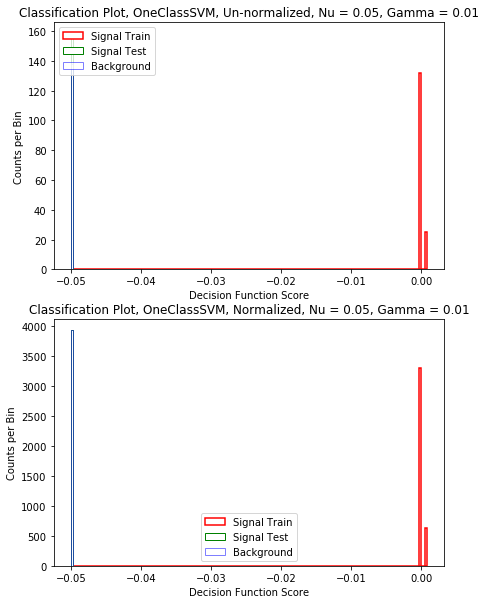

In [9]:
#%jsroot on9
%matplotlib inline
matplotlib.use('Agg')

#Sets up plot boundaries
plotMin = min(min(osvmArrs[0]), min(osvmArrs[1]), min(osvmArrs[2]))
plotMax = max(max(osvmArrs[0]), max(osvmArrs[1]), max(osvmArrs[2]))
binz = np.linspace(plotMin, plotMax, 200)

#Creates first histogram of Un-normalized Classification
plt.figure(figsize=(7, 10))
plt.subplot(211)
plt.hist(osvmArrs[0], normed = False, bins = binz, edgecolor = 'red',   
         facecolor = 'white', alpha=1, label = "Signal Train", linewidth = 1.5)
plt.hist(osvmArrs[1], normed = False, bins = binz, edgecolor = 'green', 
         facecolor = 'white', alpha=1, label = "Signal Test")
plt.hist(osvmArrs[2], normed = False, bins = binz, edgecolor = 'blue',  
         facecolor = 'white', alpha=.5, label = "Background")
plt.title("Classification Plot, OneClassSVM, Un-normalized, Nu = %s, Gamma = %s" % (nuVal,gammaVal))
plt.xlabel("Decision Function Score")
plt.ylabel("Counts per Bin")
plt.legend(loc = "upper left")

#Creates second histogram of Normalized Classification
plt.subplot(212)
plt.hist(osvmArrs[0], normed = True, bins = binz, edgecolor = 'red',   
         facecolor = 'white', alpha=1, label = "Signal Train", linewidth = 1.5)
plt.hist(osvmArrs[1], normed = True, bins = binz, edgecolor = 'green', 
         facecolor = 'white', alpha=1, label = "Signal Test")
plt.hist(osvmArrs[2], normed = True, bins = binz, edgecolor = 'blue',  
         facecolor = 'white', alpha=.5, label = "Background")
plt.title("Classification Plot, OneClassSVM, Normalized, Nu = %s, Gamma = %s" % (nuVal,gammaVal))
plt.xlabel("Decision Function Score")
plt.ylabel("Counts per Bin")
plt.legend()

#Prints relevant statistics below
print("Loss Rate                                           : ", (falseNegTest/(truePosTest+falseNegTest)*100))
print("Pollution Rate                                      : ", (falsePos/(truePosTest+falsePos))*100)
print("Number of errors on training set : ", falseNegTrain, " Percentage: ", (falseNegTrain/len(sigTrain)*100))
print("Number of errors on test set     : ", falseNegTest, " Percentage: ", (falseNegTest/len(sigTest)*100))
print("Number of errors on outliers set : ", falsePos, "  Percentage: ", (falsePos/len(X_outliers)*100))